In [2]:
!git clone https://github.com/kad99kev/FGTD.git

Cloning into 'FGTD'...


In [1]:
import os
import shutil

def copy_images(src_dir, dest_dir, n):
    """
    Copy first n images from src_dir to dest_dir

    Parameters:
    src_dir (str): Source directory
    dest_dir (str): Destination directory
    n (int): Number of images to copy
    """
    # Get list of all jpeg files in the source directory
    files = [f for f in os.listdir(src_dir) if f.endswith('.jpg')]

    # Copy first n files
    for file in files[:n]:
        shutil.copy(os.path.join(src_dir, file), dest_dir)

# Usage
src_dir = r'D:/MO3 LAP/Datasets/img_align_celeba/img_align_celeba/img_align_celeba'
dest_dir = r'D:\MO3 LAP\Datasets\img_align_celeba\fordrive'
n = 50000  # Number of images to copy
copy_images(src_dir, dest_dir, n)


In [1]:
import torch

num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")


Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [1]:
import sys
#sys.path.append('/content/FGTD/scripts')
sys.path.insert(0 , '/FGTD/scripts')

In [ ]:
!pip install -r FGTD/requirements.txt

In [2]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "D:/MO3 LAP/Graduation project/imgcap/3la2/DFGAN_midLast.ipynb"


In [3]:
import wandb
wandb.login(key="aca91a64a31e64410c0bace3adb6176b1e91c70e")
wandb.init(project="text-to-face", name="n-dfgan")


wandb: Currently logged in as: moutasem-hamdi14. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ALMU'ATASEM HAMDI\.netrc


In [4]:
import os
import random
import functools

import pandas as pd
import numpy as np
from numpy import sqrt, prod
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataclasses import asdict, dataclass

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import interpolate
from torch.nn.modules.utils import _pair
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [5]:
from FGTD.scripts.preprocess import dataset, extract_zip
from FGTD.scripts.text_encoder.sentence_encoder import SentenceEncoder

In [6]:
extract_to_path = r'D:\MO3 LAP\Datasets\img_align_celeba\img_align_celeba\img_align_celeba'

In [7]:
@dataclass
class Config:
    epochs: int = 4
    batch_size: int = 32
    subset_size: int = 20_000
    dataset_len = 202599

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    conditional: bool = True

    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    uncond_loss: int = 1.0
    colour_loss: int = 0.0
    kl_loss: int = 2.0

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [9]:
sentence_encoder = SentenceEncoder(cfg.device)

C:\Users\ALMU'ATASEM HAMDI\AppData\Roaming\Python\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [11]:
class ImageTextDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [12]:
df = ImageTextDataset(
    root_dir=extract_to_path,
    csv_file='FGTD/dataset/text_5_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
)

In [13]:
weighted_dataloader, weighted_dataiter = dataset.get_weighted_dataloader(
    'FGTD/dataset/list_attr_celeba.csv',
    custom_dataset = df,
    subset_size = cfg.subset_size,
    batch_size = cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Chubby', 'Gray_Hair', 'Eyeglasses', 'Big_Lips', 'Attractive', 'Blond_Hair', 'Double_Chin', 'Wearing_Lipstick', 'Rosy_Cheeks', 'Heavy_Makeup', 'Wearing_Earrings', 'Pale_Skin', 'Narrow_Eyes', 'Arched_Eyebrows', 'Smiling', 'Wearing_Necklace', 'Pointy_Nose', 'Wearing_Necktie', 'Mustache', 'Bushy_Eyebrows', 'Male', 'Wavy_Hair', 'Bald', 'Goatee', 'Brown_Hair', 'Straight_Hair', '5_o_Clock_Shadow', 'High_Cheekbones', 'Young', 'Receding_Hairline', 'Big_Nose', 'Oval_Face', 'Sideburns', 'Wearing_Hat', 'Black_Hair', 'Mouth_Slightly_Open'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


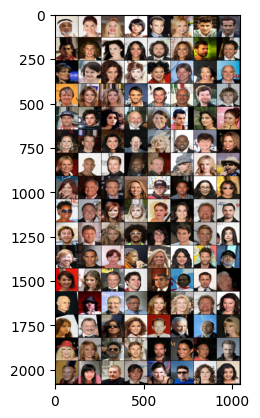

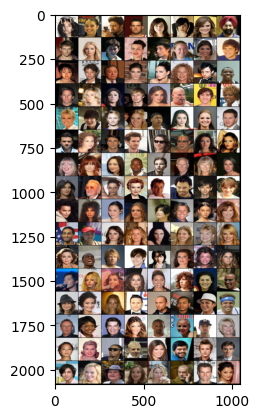

['The gentleman looks chubby and has pretty high cheekbones. He sports a goatee and has sideburns. He has a big nose. He is wearing a hat.', 'The lady has pretty high cheekbones and an oval face. She has arched eyebrows, big lips and a slightly open mouth. The female is attractive, young, is smiling and has heavy makeup. She is wearing earrings, lipstick and a necklace.', 'The female has high cheekbones and an oval face. Her hair is blond and straight. She has a slightly open mouth. She seems attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'Her hair is black. She has arched eyebrows. She seems attractive, young, has pale skin and heavy makeup. She is wearing lipstick.', 'The gentleman has pretty high cheekbones and an oval face. He has blond and straight hair. He has bushy eyebrows, a slightly open mouth and a pointy nose. The male is smiling, looks attractive, young and has pale skin. He is wearing a necktie.', 'The lady has pretty high cheekbones. She h

In [30]:
real_images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(real_images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [31]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [32]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))

    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [33]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [34]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )

  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf):
      super(D_GET_LOGITS, self).__init__()
      self.df_dim = ndf

      self.reduced_dim = nn.Linear(768, 256)

      self.joint_conv = nn.Sequential(
          nn.Conv2d(ndf * 16+256, ndf * 2, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(ndf * 2, 1, 2, 1, 0, bias=False),
      )

    def forward(self, out, y):
      y = self.reduced_dim(y)
      y = y.view(-1, 256, 1, 1)
      y = y.repeat(1, 1, 2, 2)
      h_c_code = torch.cat((out, y), 1)
      out = self.joint_conv(h_c_code)
      # print(out.shape)
      return out

In [37]:
class resD(nn.Module):
    def __init__(self, fin, fout, downsample=True):
      super().__init__()
      self.downsample = downsample
      self.learned_shortcut = (fin != fout)
      self.conv_r = nn.Sequential(
          nn.Conv2d(fin, fout, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(fout, fout, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
      )

      self.conv_s = nn.Conv2d(fin,fout, 1, stride=1, padding=0)
      self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, c=None):
      return self.shortcut(x)+self.gamma*self.residual(x)

    def shortcut(self, x):
      if self.learned_shortcut:
          x = self.conv_s(x)
      if self.downsample:
          return F.avg_pool2d(x, 2)
      return x

    def residual(self, x):
      return self.conv_r(x)

In [38]:
class NetD(nn.Module):
    def __init__(self, ndf):
      super(NetD, self).__init__()

      self.conv_img = nn.Conv2d(3, ndf, 3, 1, 1)#128
      self.block0 = resD(ndf * 1, ndf * 2)#64
      self.block1 = resD(ndf * 2, ndf * 4)#32
      self.block2 = resD(ndf * 4, ndf * 8)#16
      self.block3 = resD(ndf * 8, ndf * 16)#8
      self.block4 = resD(ndf * 16, ndf * 16)#4
      self.block5 = resD(ndf * 16, ndf * 16)#4

      self.COND_DNET = D_GET_LOGITS(ndf)

    def forward(self,x):
      out = self.conv_img(x)
      out = self.block0(out)
      out = self.block1(out)
      out = self.block2(out)
      out = self.block3(out)
      out = self.block4(out)
      out = self.block5(out)
      return out

In [39]:
netG = NetG(64, 100).to(device)
netD = NetD(64).to(device)

netG.cuda().train()
netD.cuda().train()

NetD(
  (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block0): resD(
    (conv_r): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block1): resD(
    (conv_r): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): resD(
    (conv_r): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), s

In [40]:
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004, betas=(0.0, 0.9))

In [41]:
plt_images, plt_labels, fake_img = next(weighted_dataiter)
fixed_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_embeddings.shape

torch.Size([128, 768])

In [42]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    netG.eval()
    test_images = netG(fixed_noise, fixed_embeddings)
    netG.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

In [43]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)
epochs = 4
for epoch in range(epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach())

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step()

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)


pbar.refresh()


0it [00:00, ?it/s]

Epoch : 1 / 4


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
#test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
#The woman has high cheekbones.
#She has straight hair which is
#brown in colour. She has arched
#eyebrows and a slightly open
#mouth. The smiling, young attractive woman has heavy makeup. She
#is wearing lipstick.
#'''])
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The criminal is a male. He has an oval face, short brown hair, narrow eyes, and a beard.'])

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
#test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The criminal is a woman. she is young and beautiful, and she has a straight blonde hair and a small nose.'])

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
txts = []
for i in range(10):
  real_img , txt , _ = df.__getitem__(i)
  txts.append(txt)

In [ ]:
test_noise = torch.randn(size=(10, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(txts)

In [ ]:
test_image = netG(test_noise, test_embeddings).detach().cpu()

In [ ]:
for i in range(10):
  show_grid(torchvision.utils.make_grid(test_image[i], normalize=True, nrow=10))

In [ ]:
for i in range(10):
  print(txts[i])